In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed2'
os.chdir(processed)
df = pd.read_csv('data.csv')

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20546 entries, 0 to 20545
Data columns (total 92 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   consumption_education                                    20546 non-null  float64
 1   consumption_personal                                     20546 non-null  float64
 2   income_transfers                                         20546 non-null  float64
 3   income_other                                             20546 non-null  float64
 4   consumption_clothing                                     20546 non-null  float64
 5   location_size                                            20546 non-null  int64  
 6   consumption_food                                         20546 non-null  float64
 7   consumption_current                                      20546 non-null  float64
 8   financial_income          

In [175]:
df['post'] = df['Y'] == 1996
income = ['income_salary', 'income_business', 'income_transfers']
df['income'] = df[income].sum(axis=1)
df['log_income'] = np.log(df['income'])

consumption = ['consumption_food', 'consumption_personal', 'consumption_clothing']
df['consumption'] = df[consumption].sum(axis=1)
df['log_consumption'] = np.log(df['consumption'])

/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [176]:
df = (df.query('income > 0')
      .query('consumption > 0'))

# Income Deciles
1. This section computes the income decile within each year

In [177]:
import statsmodels.stats.weightstats as ws
def get_deciles(x, weights=None):
    stats = ws.DescrStatsW(x, weights=weights)

    deciles =  np.arange(0.1, 1.1, .1)
    income_deciles = stats.quantile(deciles).values
    x_deciles = np.array([np.argmax(income_deciles > xi) for xi in x])
    return x_deciles + 1

print(len(df))
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')

20448


/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7fc3a066e940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7fc3a066e940> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)


# Dummy Variables
1. This section creates dummy variables for sex, education, location, and income decile

In [178]:
dummies ={}
dummies_names = []

df['age_sq'] = df['age'] ** 2
to_dummies = ['sex', 'education', 'location_size', 'decile']

for var in to_dummies:
    print('Making dummies for', var)
    dummies[var] = pd.get_dummies(df[var], drop_first=True, prefix=var)
    dummies_names += list(dummies[var].columns)


Making dummies for sex
Making dummies for education
Making dummies for location_size
Making dummies for decile


In [179]:
for data in dummies.values():
    df = pd.concat([df, data], axis=1)

# Interaction Dummy Variables
1. This section creates interactions with the recession and education, sex, and income decile

In [184]:
df['post_education'] = df['post'] * (pd.Categorical(df.education).codes + 1)
C_post_education = pd.get_dummies(df['post_education'], prefix='post_education', drop_first=True)
C_post_education = C_post_education.drop(columns='post_education_1')
dummies_names += list(C_post_education.columns)
df = pd.concat([df, C_post_education], axis=1)

In [185]:
df['post_sex'] = df['post'] * (pd.Categorical(df.sex).codes + 1)
C_post_sex = pd.get_dummies(df['post_sex'], prefix='post_sex', drop_first=True)
C_post_sex = C_post_sex.drop(columns='post_sex_1')
dummies_names += list(C_post_sex.columns)
df = pd.concat([df, C_post_sex], axis=1)

In [186]:
df['post_decile'] = df['post'] * df['decile']
C_post_decile = pd.get_dummies(df['post_decile'], prefix='post_decile')
C_post_decile = C_post_decile.drop(columns=['post_decile_0'])
dummies_names += list(C_post_decile.columns)
df = pd.concat([df, C_post_decile], axis=1)

In [187]:
continuous = ['age', 'age_sq']
X_col = continuous + dummies_names
X = df[X_col]
Y = df[['log_income']]

In [188]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X, Y, sample_weight=df['weight'])
linear.coef_

array([[-3.75003489e-03,  5.38381485e-05, -8.17599778e-03,
        -9.18535816e-02, -9.17224284e-02, -1.00769641e-02,
        -1.58164658e-02, -4.64656347e-02,  7.66014930e-01,
         1.10476525e+00,  1.37024759e+00,  1.60526404e+00,
         1.84127299e+00,  2.09947686e+00,  2.40222631e+00,
         2.82345726e+00,  3.65900219e+00,  8.52087472e-03,
         1.11394766e-02, -1.98938086e-03, -2.05499631e-01,
        -2.34747044e-01, -2.43078162e-01, -2.40850928e-01,
        -2.50666317e-01, -2.59953380e-01, -2.77454407e-01,
        -3.02091048e-01, -3.30031622e-01, -3.46298291e-01]])

In [195]:
nboot = 200
coef_income = np.ones((nboot, 10), dtype=np.float64)
coef_consumption = np.ones((nboot, 10), dtype=np.float64)

In [196]:
for boot in np.arange(nboot):
    df_boot = df.sample(len(df), replace=True, weights=df['weight'], axis=0)
    X = df_boot[X_col]
    Y_income = df_boot[['log_income']]
    Y_consumption = df_boot[['log_consumption']]

    linear.fit(X, Y_income)
    coef_income[boot, :] = np.squeeze(linear.coef_)[-10:]

    linear.fit(X, Y_consumption)
    coef_consumption[boot, :] = np.squeeze(linear.coef_)[-10:]

In [197]:
coef_elasticity = coef_consumption / coef_income

In [198]:
coef_income_q10 = np.quantile(coef_income, q=0.10, axis=0)
coef_income_q90 = np.quantile(coef_income, q=0.90, axis=0)
coef_income_mean = np.mean(coef_income, axis=0)

coef_consumption_q10 = np.quantile(coef_consumption, q=0.10, axis=0)
coef_consumption_q90 = np.quantile(coef_consumption, q=0.90, axis=0)
coef_consumption_mean = np.mean(coef_consumption, axis=0)

coef_elasticity_q10 = np.quantile(coef_elasticity, q=0.10, axis=0)
coef_elasticity_q90 = np.quantile(coef_elasticity, q=0.90, axis=0)
coef_elasticity_mean = np.mean(coef_elasticity, axis=0)

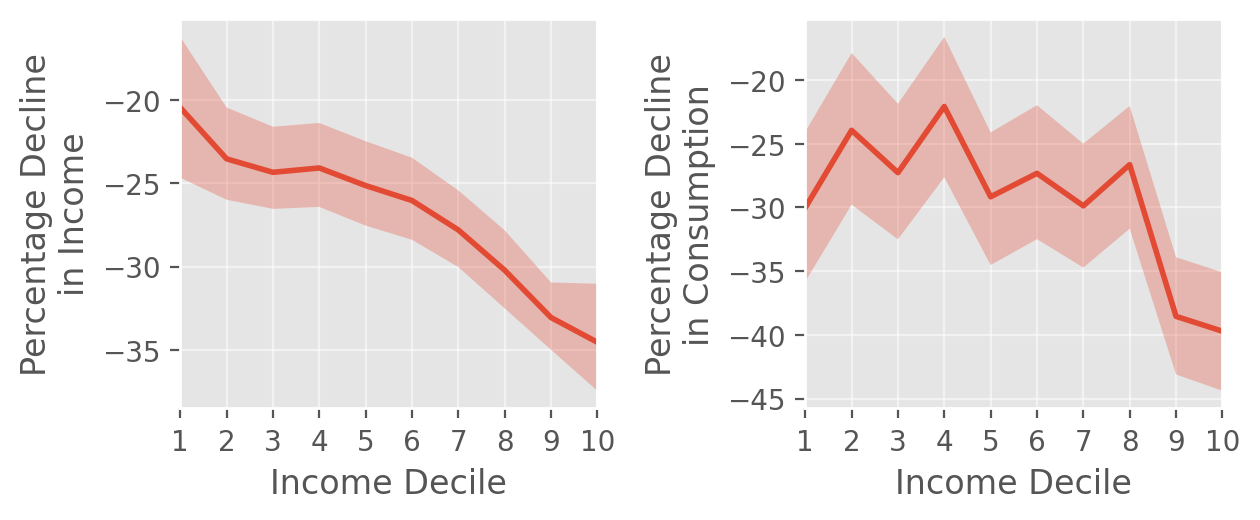

In [199]:
deciles = np.arange(1, 11)

plt.subplot(221)
plt.plot(deciles, 100*coef_income_mean)
plt.fill_between(deciles, 100*coef_income_q10, 100*coef_income_q90, alpha=0.3)
plt.xticks(deciles)
plt.xlabel('Income Decile')
plt.ylabel('Percentage Decline\nin Income')

plt.subplot(222)
plt.plot(deciles, 100*coef_consumption_mean)
plt.fill_between(deciles, 100*coef_consumption_q10, 100*coef_consumption_q90, alpha=0.3)
plt.xticks(deciles)
plt.xlabel('Income Decile')
plt.ylabel('Percentage Decline\nin Consumption');

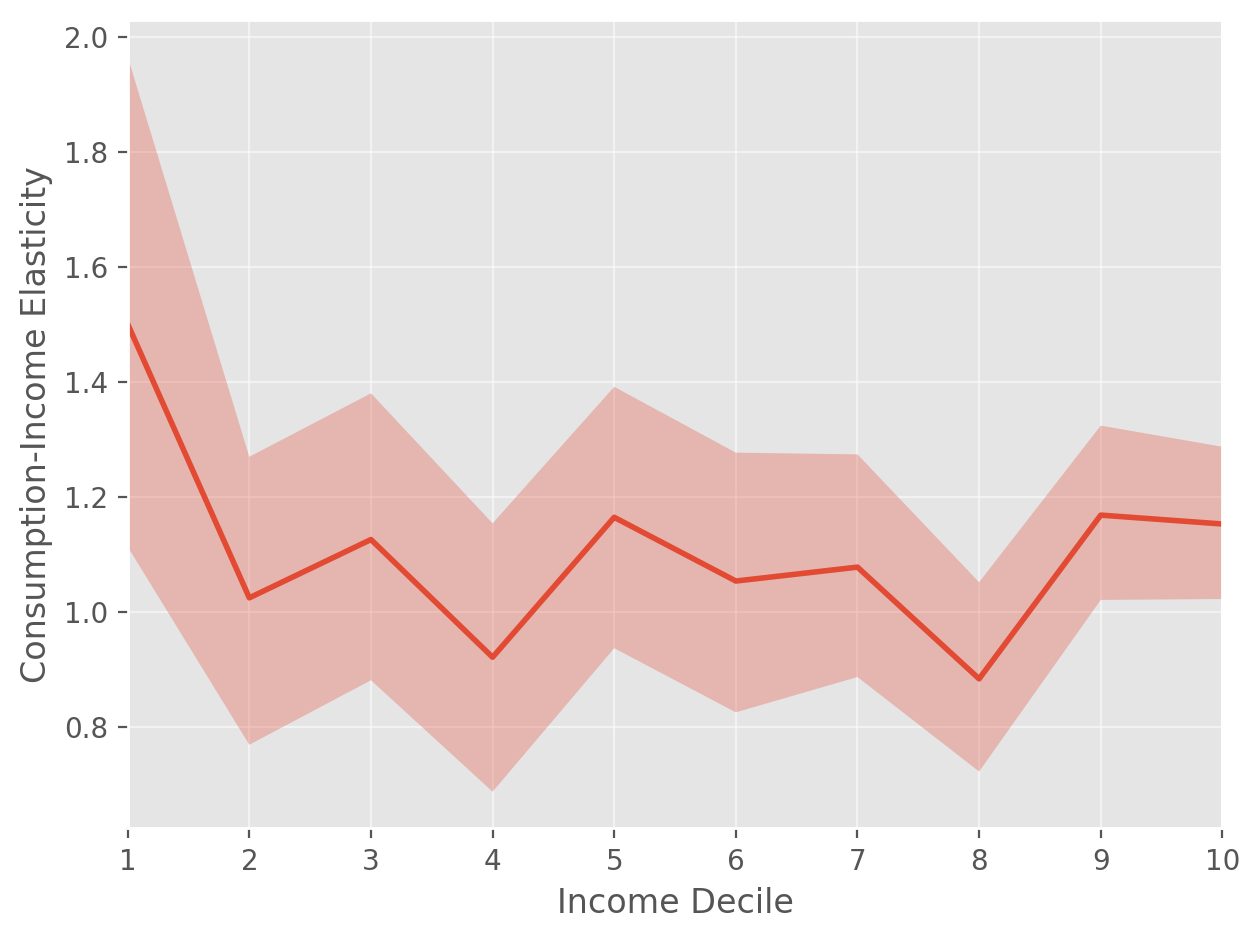

In [200]:
plt.plot(deciles, coef_elasticity_mean)
plt.fill_between(deciles, coef_elasticity_q10, coef_elasticity_q90, alpha=0.3)
plt.ylabel('Consumption-Income Elasticity')

plt.xticks(deciles)
plt.xlabel('Income Decile');